In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.decisions.control_charts import *

plt.rcParams.update({'font.size': 16})

In [3]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
models_folder = os.path.join(package_folder, 'models')
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected['timestamp'] = pd.to_datetime(ss2_selected['timestamp'])
ss2_selected.set_index('timestamp', inplace=True)

SS1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS1_mode.parquet'))
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
FA1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA1_mode.parquet'))
FA2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA2_mode.parquet'))

rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

In [4]:
rfe_selected_data.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_winddirection'],
      dtype='object')

# SS1

In [5]:
all_predicitons = {}
all_smart_tracked = {}
all_modal_data = {}

In [6]:
mode = 'SS1'



X = rfe_selected_data.copy()
y = SS1_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]
y = y.sort_index()

#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y.copy()
for col in X.columns:
    Xy[col] = X[col]
X = Xy[X.columns]
y = y[y.columns]

# Split in training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= False) # , random_state=42)

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.9)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].quantile(0.99)
prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()*3


smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']

all_smart_tracked[mode] = smart_tracked_modes
all_predicitons[mode] = predictions_df
all_modal_data[mode] = y

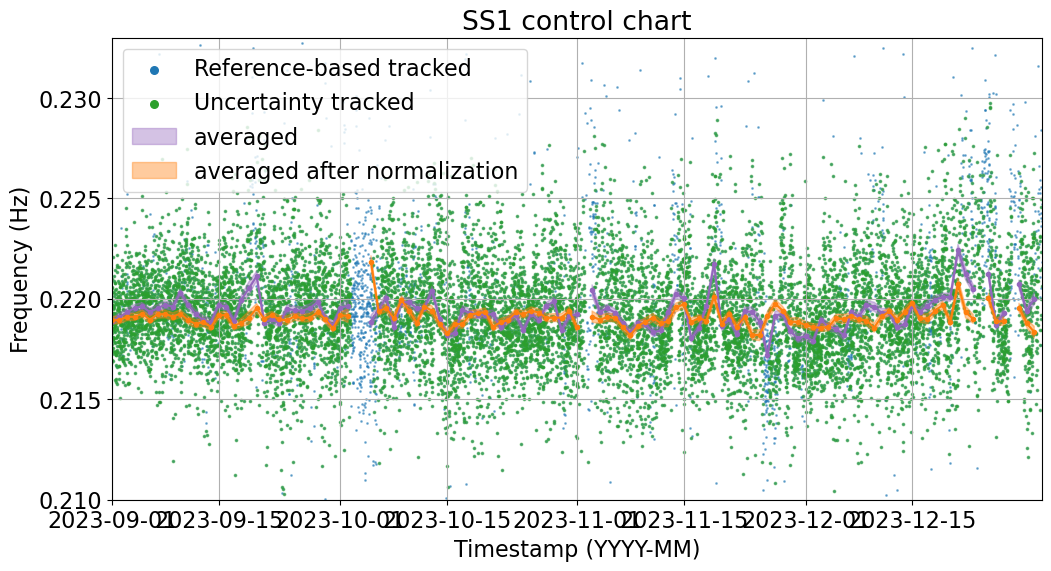

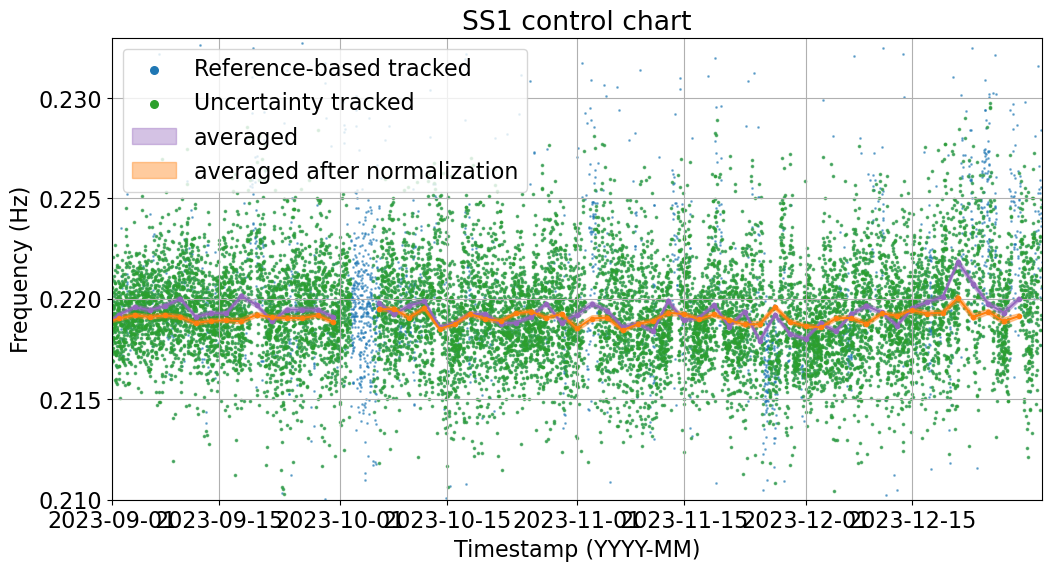

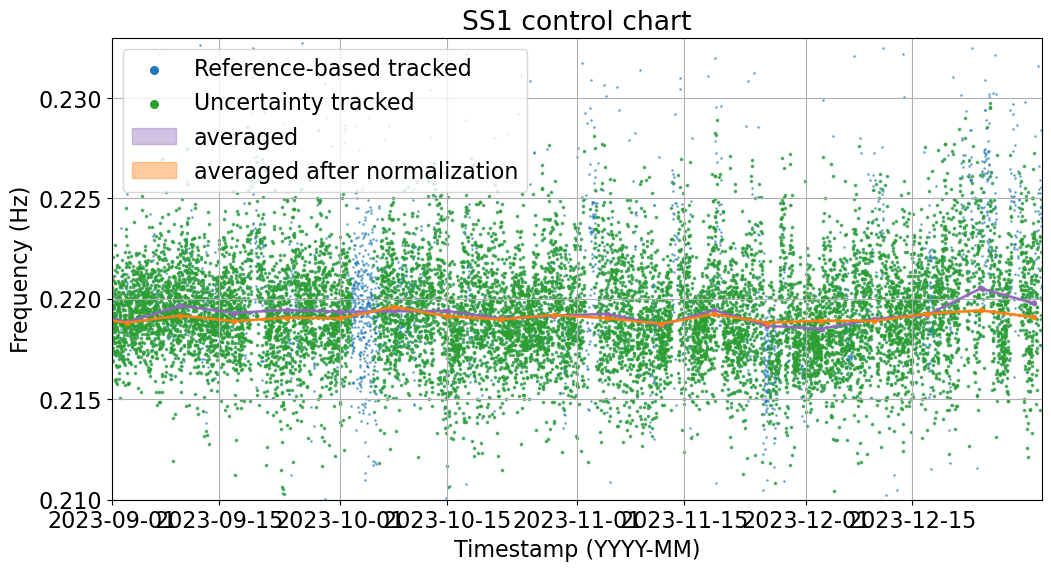

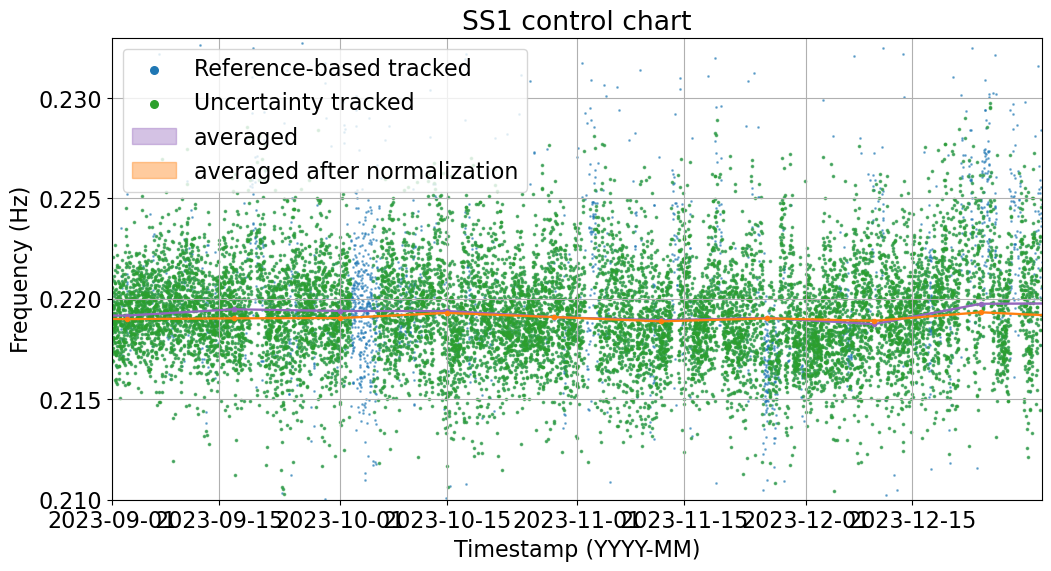

In [7]:
plot_control_charts(
    smart_tracked_modes,
    y,
    predictions_df,
    mode,
    start=datetime.datetime(2023, 9, 1),
    end=smart_tracked_modes.index[-1],
    ylim=(0.21, 0.233),
)

# FA1

In [8]:
mode ='FA1'

X = rfe_selected_data.copy()
y = FA1_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]

#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y.copy()
for col in X.columns:
    Xy[col] = X[col]
X = Xy[X.columns]
y = y[y.columns]

# Split in training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_.loc[X_train.index].quantile(0.9)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()*3

smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']

all_smart_tracked[mode] = smart_tracked_modes
all_predicitons[mode] = predictions_df
all_modal_data[mode] = y

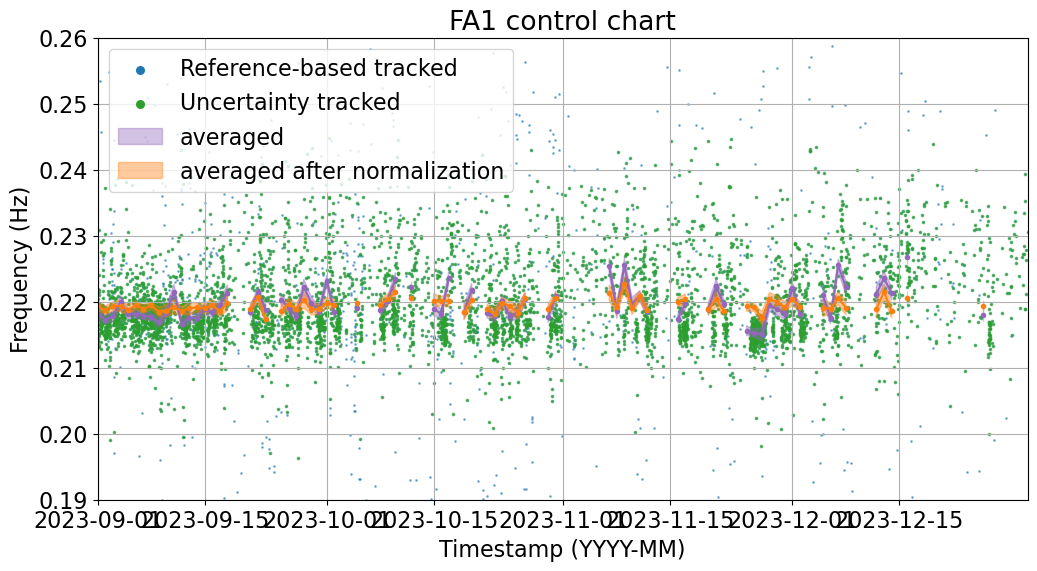

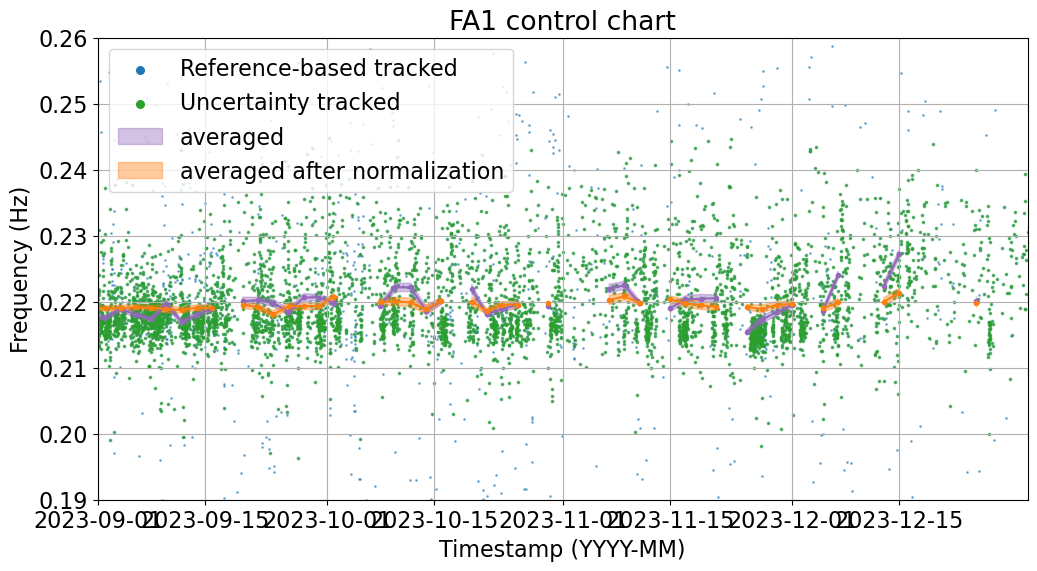

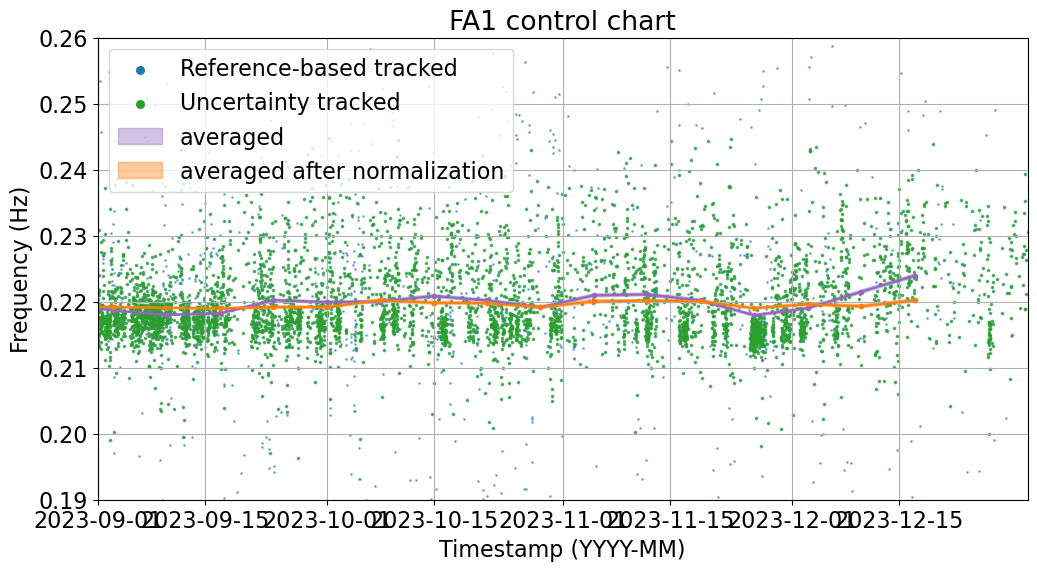

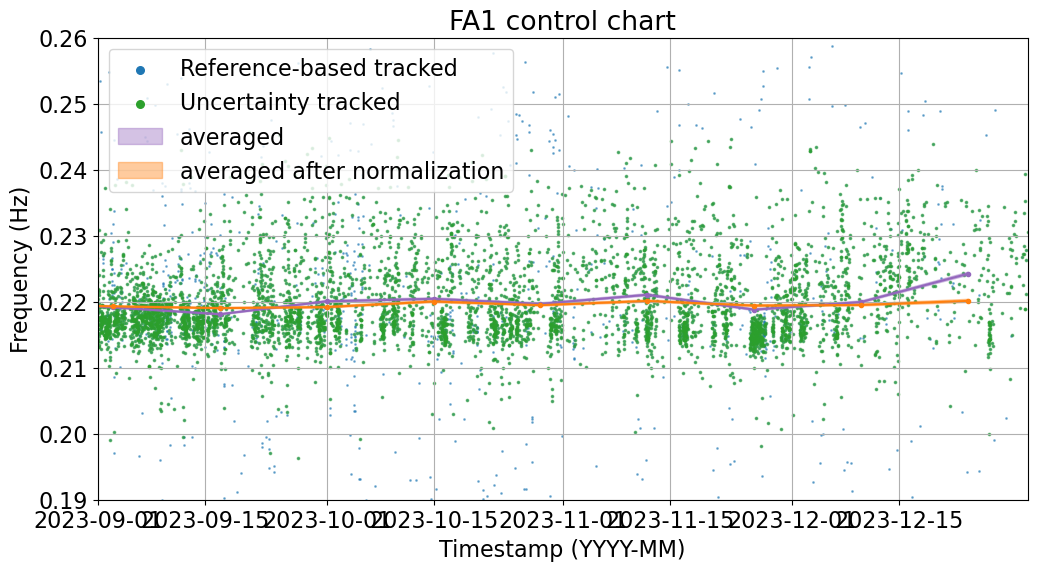

In [9]:
plot_control_charts(
    smart_tracked_modes,
    y,
    predictions_df,
    mode,
    start=datetime.datetime(2023, 9, 1),
    end=smart_tracked_modes.index[-1],
    ylim=(0.19, 0.26)
)

In [10]:
mode ='SS2'

X = rfe_selected_data.copy()
y_ = ss2_selected.copy()
y_ = y_.sort_values(by=['size'])
y_ = y_[~y_.index.duplicated(keep='first')][['mean_frequency']]

y = SS2_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]
#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y_.copy()
for col in X.columns:
    Xy[col] = X[col]
X_train = Xy[X.columns]
y_train = y_[y_.columns]

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.2,
    l2_leaf_reg=5,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=200, ntree_end=500) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_.loc[X_train.index].quantile(0.8)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()


smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']

all_smart_tracked[mode] = smart_tracked_modes
all_predicitons[mode] = predictions_df
all_modal_data[mode] = y

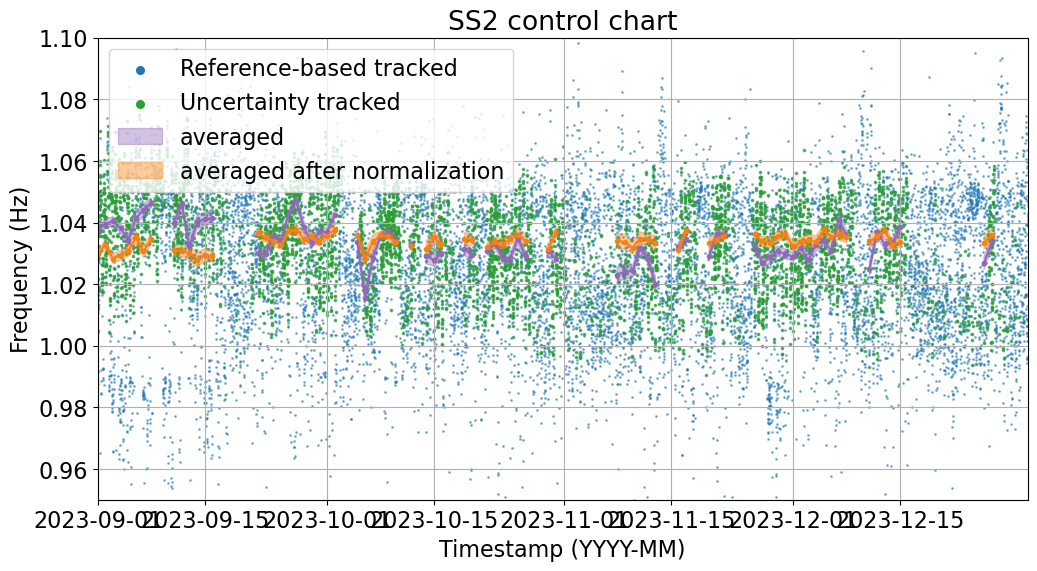

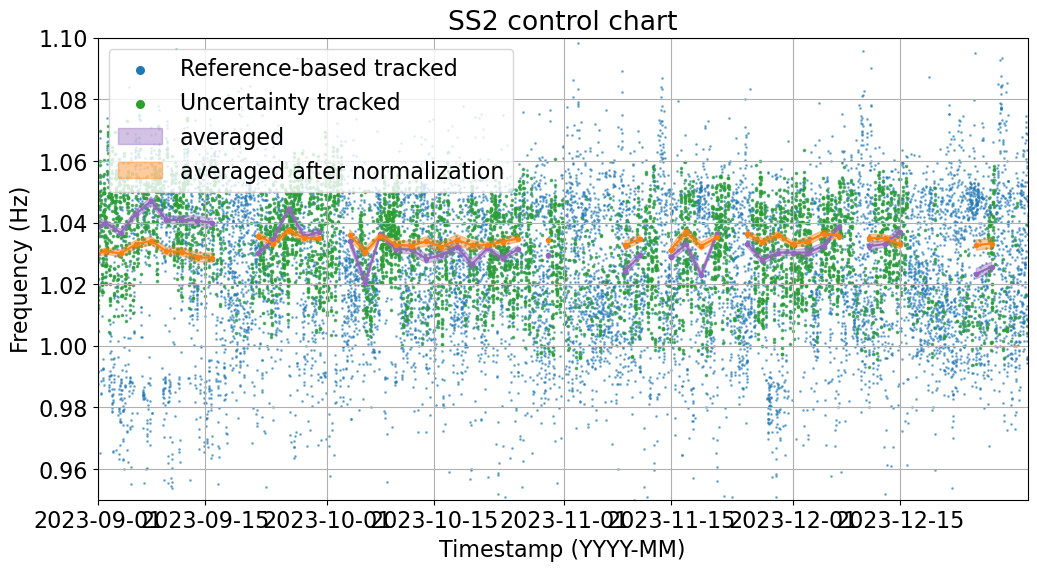

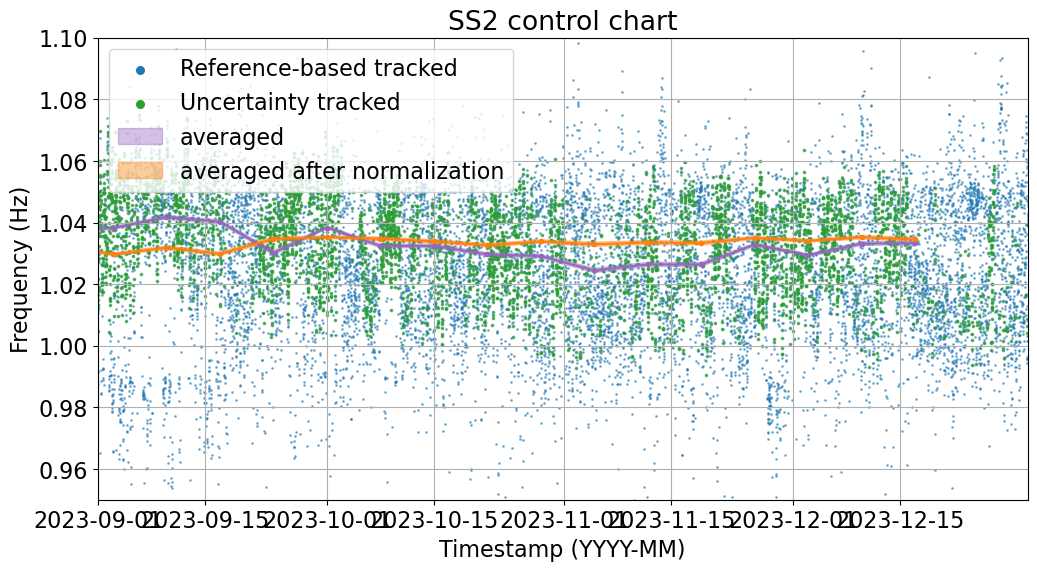

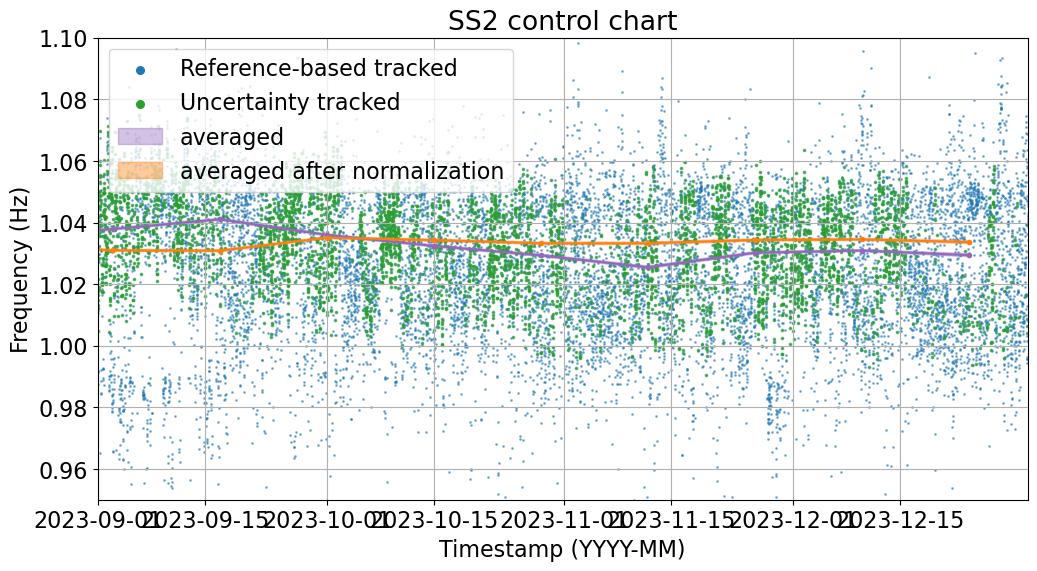

In [11]:
plot_control_charts(
    smart_tracked_modes,
    y,
    predictions_df,
    mode,
    start=datetime.datetime(2023, 9, 1),
    end=smart_tracked_modes.index[-1],
    ylim=(0.95, 1.1),
)

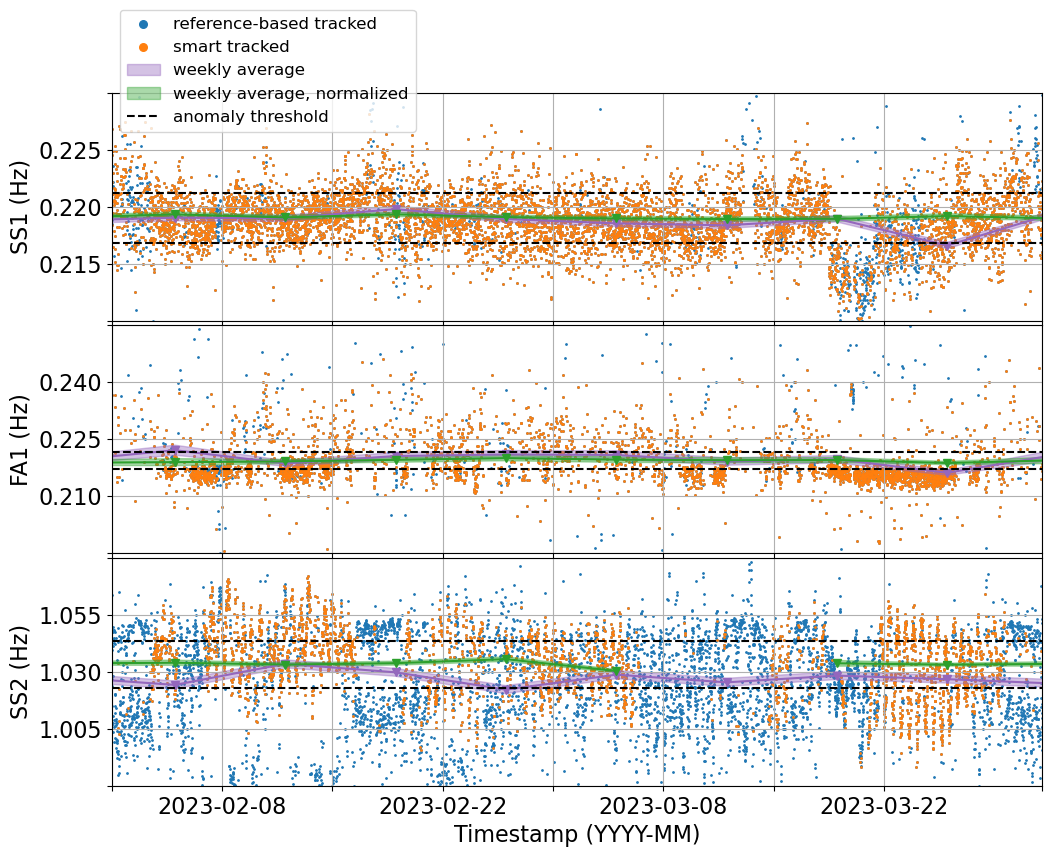

In [12]:
from src.decisions.control_charts import *

plot_decision_charts(
    all_smart_tracked,
    all_modal_data,
    all_predicitons,
    start = datetime.datetime(2023, 2, 1),
    end = datetime.datetime(2023, 4, 1),
    ylims={
        'SS1': (0.21, 0.23),
        'FA1': (0.195, 0.255),
        'SS2': (0.98, 1.08),
    },
    confidence = 0.99,
    timespans=['W']
)

In [13]:
mode = 'SS2'
smart_tracked_path = os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_smart_tracked_modes_all_data.parquet')
all_smart_tracked[mode].to_parquet(smart_tracked_path)

In [14]:
all_modal_data[mode]

mean_frequency
timestamp                                
2023-03-07 03:20:00+00:00        1.015916
2022-11-16 14:40:00+00:00        0.983012
2023-12-14 21:30:00+00:00        1.023392
2023-04-10 02:20:00+00:00        1.001171
2022-12-13 17:40:00+00:00        1.004661
...                                   ...
2022-11-06 02:20:00+00:00        1.044453
2023-11-20 04:30:00+00:00        1.035829
2023-02-05 14:50:00+00:00        1.037472
2023-10-31 21:40:00+00:00        1.050419
2023-10-28 20:40:00+00:00        1.047078

[60442 rows x 1 columns]